In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from scripts import featurizer_rf


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,precision_score ,f1_score

In [4]:
df = pd.read_csv("../data/dataset-procesado.csv", index_col=False)

In [5]:
df_trabajo = featurizer_rf.featurizer(df)

----rf-featurizer----


In [6]:
df_trabajo.shape

(263965, 138)

In [7]:
df_trabajo.columns

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'D_43', 'D_44',
       'B_4',
       ...
       'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ', 'customer_id_repeat_size',
       'd_feats_mean', 's_feats_mean', 'p_feats_mean', 'b_feats_mean',
       'r_feats_mean'],
      dtype='object', length=138)

In [8]:
#Separo en train y test para trabajar los modelos
df_trabajo_x=df_trabajo.drop(['target'], axis='columns', inplace=False)

df_trabajo_y = df_trabajo['target'].copy()
#Uso parametro stratify para balancear el target dentro de cada ser de datos de train test
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, df_trabajo_y, test_size=0.3, random_state=1, stratify = df_trabajo_y)

Modelo Random forest

Buscamos los mejores hiperparametros para el modelo Random forest

In [9]:
rf_cv = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5], 
               "max_features":["sqrt", "log2"],
               "min_samples_split" : [2, 5], 
               "n_estimators": [10,50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

In [10]:
gs_fit = gs.fit(X = x_train, y = y_train)
best_params_rfc = gs_fit.best_params_

print(best_params_rfc)

{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}


Predecimos utilizando el mejor modelo q obtuvimos

In [11]:
rfc_best_model = RandomForestClassifier(**best_params_rfc)

In [12]:
model_rfc = rfc_best_model.fit(X = x_train,y = y_train)
y_pred_rfc = model_rfc.predict(x_test)
df_resultados_rfc=pd.DataFrame(zip(y_test,y_pred_rfc),columns=['test','predicted'])

Vamos a guardar el RFC en un archivo

In [19]:
import joblib
joblib.dump(model_rfc, "./random_forest.joblib")

['./random_forest.joblib']

In [15]:
df_resultados_rfc.sample(5)

,test,predicted
65849,1,1
13537,0,0
18844,0,0
58151,0,0
30547,1,1


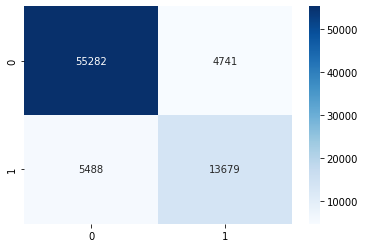

In [16]:
tabla=confusion_matrix(df_resultados_rfc['test'], df_resultados_rfc['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [17]:
def results_comparation(df_predict):
    df_predict["success"] = (df_predict["test"] == df_predict["predicted"])
    df_predict["success"].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("Cantidad de valores predecidos correctamente") 
    plt.show()

    precicion = precision_score(df_predict['test'], df_predict['predicted'])
    f1=f1_score(df_predict['test'], df_predict['predicted'])
    recall = recall_score(df_predict['test'], df_predict['predicted'])
    
    print(f"Precision score: \t{round(precicion,3)}")
    print(f"Recall score: \t\t{round(recall,3)}")
    print(f"F1 score: \t\t{round(f1,3)}")

    accuracy=accuracy_score(df_predict['test'], df_predict['predicted'], normalize=True)
    print("Tiene una accuracy del: " + str(round(accuracy, 3)) + "% como muestra el pie chart")


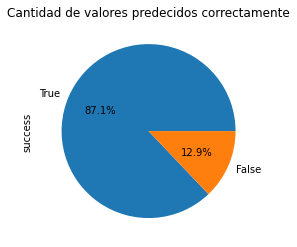

Precision score: 	0.743
Recall score: 		0.714
F1 score: 		0.728
Tiene una accuracy del: 0.871% como muestra el pie chart


In [18]:
results_comparation(df_resultados_rfc)